In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import re
from collections import Counter

## Cleaning and Parsing

This data set is a test set provided by Reuters with 50 authors, who each have 50 articles a piece. In total, that leaves us with 2500 articles.

In our notebook today we are going to demonstrate some basic NLP feature creation, and different clustering and supervised learning methods that these features can be funneled into for predictive purposes.

-------------------

The first priority, as always, is cleaning and parsing our data. Because our data is organized in multiple, hierarchical folders we will have to loop through all of these and extract the necessary text.

**While cleaning we remove**:
- *'-'* characters, as SpaCy (our NLP text reader) cannot process this character
- End of article notations, including dates and author names

**We also parsed the data using SpaCy, and separated each article into 2 distinct sets of SpaCy tokens**:
- with entities
- without entities


Entities in this case are typically defined as proper nouns, such as names, locations and events. By removing entities as a part of feature generation, our goal here is to test whether biasing our predictive models towards authors' writing styles (no entities feature set) vs. topics that the authors cover (entities feature set) makes a difference in predictions.

In [2]:
# Set directory for reading training articles
import os
os.chdir('/Users/Albert/Desktop/Thinkful_Drills/Data/Unsupervised Learning/C50/C50train')

# Load English language option in spaCy
nlp = spacy.load('en')

# Set blank list for data
article_read = []

# Create for loop to open each author folder
for author in sorted(os.listdir('.'))[1:]:
    # Create for loop to read each article in folder
    path = os.path.join('.', author)
    for article in os.listdir(path):
        # Read article
        file = open(os.path.join(path, article), 'r')
        text = file.read()
        # Clean text of end of article notations and characters spaCy cannot read
        text = re.sub('\-\-.*$', '', text)
        text = re.sub('\(\(.*$', '', text)
        text = re.sub(r'-', ' ', text)
        text = ' '.join(text.split())
        # Parse data using spaCy
        text = nlp(text)
        # Create separate set of tokens with no entities for later use in feature creation
        text_no_entities = text.text
        for entity in text.ents:
            text_no_entities = text_no_entities.replace(entity.text, '')
        text_no_entities = ' '.join(text_no_entities.split())
        text_no_entities = nlp(text_no_entities)
        # Append all information to articles list
        article_read.append([text, text_no_entities, author])
    # Print author to keep track of where parsing code is
    print (author)

        
# Convert article list to Pandas DataFrame
article_df = pd.DataFrame(article_read, columns=['article_text','article_no_entities','author_name'])
article_df.head()

AaronPressman
AlanCrosby
AlexanderSmith
BenjaminKangLim
BernardHickey
BradDorfman
DarrenSchuettler
DavidLawder
EdnaFernandes
EricAuchard
FumikoFujisaki
GrahamEarnshaw
HeatherScoffield
JanLopatka
JaneMacartney
JimGilchrist
JoWinterbottom
JoeOrtiz
JohnMastrini
JonathanBirt
KarlPenhaul
KeithWeir
KevinDrawbaugh
KevinMorrison
KirstinRidley
KouroshKarimkhany
LydiaZajc
LynneO'Donnell
LynnleyBrowning
MarcelMichelson
MarkBendeich
MartinWolk
MatthewBunce
MichaelConnor
MureDickie
NickLouth
PatriciaCommins
PeterHumphrey
PierreTran
RobinSidel
RogerFillion
SamuelPerry
SarahDavison
ScottHillis
SimonCowell
TanEeLyn
TheresePoletti
TimFarrand
ToddNissen
WilliamKazer


,article_text,article_no_entities,author_name
0,"(A, group, of, leading, trademark, specialists...","(A, group, of, leading, trademark, specialists...",AaronPressman
1,"(Prospects, for, comprehensive, reform, of, U....","(Prospects, for, comprehensive, reform, of, ba...",AaronPressman
2,"(An, influential, economic, research, group, i...","(An, influential, economic, research, group, i...",AaronPressman
3,"(The, Federal, Communications, Commission, pro...","(proposed, to, trim, the, a, year, that, long,...",AaronPressman
4,"(An, international, task, force, charged, with...","(An, international, task, force, charged, with...",AaronPressman


## Bag of Words Feature Creation

For our first feature creation method we are going to use Bag of Words (BoW). This method is premised on summing up word counts by article.

--------------

In this particular situation, we chose our desired words to fill our feature set as follows:
- **No stopwords** - you can run the following if you are curious what these are:
        from spacy.en.language_data import STOP_WORDS
- **No punctuations** - *EXCEPT* for quotation marks
- **Top 1000 Per Author** - Pulled out the top 1000 words per author, then aggregated into our final feature set

In [3]:
## DETERMING SET OF MOST COMMON WORDS

# Create a set of article strings by author to help with BoW feature creation
text_by_author = []
text_by_author_no_entities = []


for author in article_df.author_name.unique():
    for text in article_df[article_df['author_name'] == author].article_text:
        text_aggregator = ''
        text_aggregator = text_aggregator + ' ' + str(text)
        text_by_author.append([text_aggregator, author])
    for text in article_df[article_df['author_name'] == author].article_no_entities:
        text_aggregator = ''
        text_aggregator = text_aggregator + ' ' + str(text)
        text_by_author_no_entities.append([text_aggregator, author])
    
    
# Create feature to pull 1000 most common words by author, removing all stopwords and punctuation EXCEPT " (quotation marks)
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    quotes = nlp('"')
    allwords = [token.lemma_
                for token in text
                if not token.is_stop
                and (token == quotes[0] or not token.is_punct) 
                ]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]


# Pull desired set of words from text for both feature set types
common_words = set()
common_words_no_entities = set()

for author in text_by_author:
    words_bagged_by_author = bag_of_words(nlp(author[0]))
    common_words = common_words.union(words_bagged_by_author)
    
for author in text_by_author_no_entities:
    words_bagged_by_author = bag_of_words(nlp(author[0]))
    common_words_no_entities = common_words_no_entities.union(words_bagged_by_author)

In [4]:
## CREATING FEATURE SET WITH COUNT OF EACH WORD PER ARTICLE 


def bow_features(articles, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(articles)
    df = pd.concat([df, pd.DataFrame(columns=common_words)], axis=1)
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, article in enumerate(df.iloc[:,0]):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        quotes = nlp('"')
        words = [token.lemma_
                 for token in article
                 if token.lemma_ in common_words
                 and not token.is_stop  
                 and (token == quotes[0] or not token.is_punct) 
                ]

        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1

                    
    return df


# Convert to DataFrame for each feature set type
bow_entities = bow_features(article_df[['article_text','author_name']], common_words)
print(bow_entities.shape)

bow_no_entities = bow_features(article_df[['article_no_entities','author_name']], common_words_no_entities)
print(bow_no_entities.shape)

(2500, 27217)
(2500, 15640)


That's a pretty hefty set of features! Luckily, we're working with a sparse matrix so we can compress the feature set down significantly while still maintaining most of the information.

We'll do this using PCA

In [5]:
# Import PCA tools
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Prep data and set dimension target
normed1 = normalize(bow_entities.iloc[:,2:])
normed2 = normalize(bow_no_entities.iloc[:,2:])
pca = PCA(850)

# Run PCA to reduce BoW dimensions to 850
bow_entities = pca.fit_transform(normed1)
bow_entities = pd.DataFrame(bow_entities)
print('BoW PCA contains {:.3f}% of original variance'.format(pca.explained_variance_ratio_.sum()*100))

bow_no_entities = pca.fit_transform(normed2)
bow_no_entities = pd.DataFrame(bow_no_entities)
print('BoW No Entities PCA contains {:.3f}% of original variance'.format(pca.explained_variance_ratio_.sum()*100))

BoW PCA contains 88.638% of original variance
BoW No Entities PCA contains 90.865% of original variance


We were able to shrink down each feature set from 27,000 and 15,000 to 850 while still retaining about 90% of our original variance. Good job team!

## tf-idf Feature Creation

In order to be comprehensive in exploring our data, we will also utilize a second type of feature creation method - Term Frequence - Inverse Document Frequency.

In short, this method uses a ratio of Term Frequency *(how many times a word appears in an observed article)* over Document Frequency *(how many articles that word appears in for all observed articles)*. This allows us to weight words that occur often within a smaller number of sentences heavily, and words that occur in most or all sentences less so. In other words, we find the most distinguishing and unique words in a set of texts and highlight them.

In [6]:
# Create sets of articles to transform using tf-idf vectorizer
list_of_articles = [article.text for article in article_df.article_text]
list_of_articles_no_entities = [article.text for article in article_df.article_no_entities]

In [7]:
# Import and set parameters for tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.4, # drop words that occur in more than 40% of articles
                             min_df=5, # only use words that appear in at least 5 articles
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm='l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Apply the vectorizer
articles_tfidf=vectorizer.fit_transform(list_of_articles)
print("Number of features in articles: {}".format(articles_tfidf.get_shape()[1]))

articles_no_entities_tfidf=vectorizer.fit_transform(list_of_articles_no_entities)
print("Number of features in articles with no entities: {}".format(articles_no_entities_tfidf.get_shape()[1]))

Number of features in articles: 10418
Number of features in articles with no entities: 8093


Once we have our feature set of vectorized words, we can now again apply a clustering compression technique to shrink down our feature set

In [8]:
# Import packages for transforming our applying LSA to our tf-idf matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer. We are going to reduce the feature space to 250 dimensions.
svd = TruncatedSVD(850)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on both feature sets
article_lsa = lsa.fit_transform(articles_tfidf)
variance_explained_1=svd.explained_variance_ratio_

article_no_entities_lsa = lsa.fit_transform(articles_tfidf)
variance_explained_2=svd.explained_variance_ratio_

print("Percent variance captured by article components:", variance_explained_1.sum()*100)
print("Percent variance captured by article components with no entities:", variance_explained_2.sum()*100)

#Converting to DataFrame
lsa_entities = pd.concat([article_df[['article_text','author_name']], pd.DataFrame(article_lsa)], axis=1, ignore_index=True)
lsa_no_entities = pd.concat([article_df[['article_no_entities','author_name']], pd.DataFrame(article_no_entities_lsa)], axis=1, ignore_index=True)

Percent variance captured by article components: 81.64864604258413
Percent variance captured by article components with no entities: 81.64573630765565


We shrunk our set of features down to 850 attributes for each feature set type. Unfortunately, we were only able to retain approximately 80% of variance in this situation.

## Feature Set Summary

To wrap up, below you will find a snapshot of all 4 of our feature sets along with their size and shape

In [9]:
print (bow_entities.shape)
bow_entities.head(5)

(2500, 850)


,0,1,2,3,4,5,6,7,8,9,...,840,841,842,843,844,845,846,847,848,849
0,0.092275,-0.146750,0.106172,-0.060062,-0.094325,-0.039037,0.081718,-0.004693,0.055184,-0.018770,...,0.014350,0.001837,0.003689,0.002612,-0.008066,0.018712,0.001584,-0.006584,-0.010669,-0.003387
1,0.019367,-0.142554,0.095405,0.101823,-0.030323,-0.119020,0.072044,-0.099093,-0.083941,-0.064355,...,-0.009993,-0.000207,0.019108,-0.003014,-0.006742,-0.017441,0.001941,-0.000338,0.020364,0.020543
2,0.114846,-0.143896,-0.044041,0.060925,-0.054318,-0.036330,0.008263,0.022026,0.029703,-0.047370,...,0.006930,-0.005928,-0.007198,-0.013940,0.007180,0.001202,0.009335,0.009855,-0.006730,-0.001617
3,-0.039406,-0.274087,0.051575,-0.100198,-0.037599,-0.127704,0.182866,0.072151,0.141448,0.020599,...,-0.002211,0.014696,-0.001981,0.009294,0.009341,-0.000311,-0.018174,-0.017258,0.003604,-0.001616
4,0.057261,-0.223574,0.060231,-0.077765,-0.112014,-0.078972,0.187995,-0.062511,0.142707,0.030234,...,0.016845,-0.012989,-0.009106,0.005592,0.003393,-0.005665,0.012666,-0.003440,0.002801,-0.006660


In [10]:
print (bow_no_entities.shape)
bow_no_entities.head(5)

(2500, 850)


,0,1,2,3,4,5,6,7,8,9,...,840,841,842,843,844,845,846,847,848,849
0,-0.156229,0.141027,0.073966,-0.066405,0.039787,-0.012144,0.011953,0.081604,-0.071373,-0.082627,...,-0.000572,-0.001852,0.022305,-0.001879,-0.000874,0.001601,0.006110,0.002212,-0.002498,-0.013687
1,-0.042502,0.073166,0.049617,-0.104295,-0.161186,0.206347,-0.093493,0.060847,-0.010967,0.002953,...,0.014915,0.003232,0.009929,-0.015792,0.005071,0.000279,0.004276,-0.008671,-0.002838,-0.005759
2,-0.137849,-0.015848,0.007792,-0.070354,-0.006041,-0.013467,0.017807,-0.002905,0.001758,-0.091855,...,0.009516,-0.000446,0.006644,-0.009147,0.000258,0.001478,0.001425,-0.006917,0.000195,0.012154
3,-0.031879,0.218798,0.256913,-0.216722,-0.056125,-0.034580,0.119072,0.001044,0.064660,-0.014641,...,-0.012873,0.001383,-0.001986,0.004930,0.002258,0.003486,0.001475,-0.002699,0.001731,0.002300
4,-0.133025,0.176782,0.139248,-0.273358,0.080779,-0.023244,0.031067,-0.015449,-0.079978,-0.013338,...,-0.003023,0.003748,-0.000559,-0.001520,0.003807,-0.000174,-0.001966,0.004863,0.002677,0.011140


In [11]:
print(lsa_entities.shape)
lsa_entities.head(5)

(2500, 852)


,0,1,2,3,4,5,6,7,8,9,...,842,843,844,845,846,847,848,849,850,851
0,"(A, group, of, leading, trademark, specialists...",AaronPressman,0.087488,-0.014777,-0.010151,-0.071998,-0.012022,0.042939,0.059001,-0.018199,...,0.020555,-0.032765,-0.011603,-0.047281,0.045926,0.023067,0.003756,-0.005860,-0.013574,0.058953
1,"(Prospects, for, comprehensive, reform, of, U....",AaronPressman,0.233478,-0.048143,-0.039906,0.062504,0.032346,0.018787,-0.029914,0.029666,...,-0.004246,0.007609,0.012333,0.016102,-0.031562,0.018708,-0.031532,0.006041,-0.026242,-0.009361
2,"(An, influential, economic, research, group, i...",AaronPressman,0.147762,-0.007591,-0.012820,-0.045595,-0.000826,0.075849,0.044045,-0.036844,...,0.014678,0.008134,0.010827,0.009338,-0.018205,0.019709,-0.006871,-0.021439,-0.000563,0.000348
3,"(The, Federal, Communications, Commission, pro...",AaronPressman,0.183664,-0.064690,-0.006218,-0.169845,0.122824,0.084941,0.137778,-0.055975,...,0.022780,-0.009275,-0.027484,-0.036072,0.052686,0.014101,0.004318,0.007240,0.010437,0.022228
4,"(An, international, task, force, charged, with...",AaronPressman,0.131897,-0.016022,-0.009722,-0.113001,-0.020529,0.069145,0.100344,-0.042403,...,-0.000816,-0.006790,-0.008681,0.016420,-0.000804,-0.011772,-0.002097,-0.009395,-0.017694,-0.018267


In [12]:
print(lsa_no_entities.shape)
lsa_no_entities.head(5)

(2500, 852)


,0,1,2,3,4,5,6,7,8,9,...,842,843,844,845,846,847,848,849,850,851
0,"(A, group, of, leading, trademark, specialists...",AaronPressman,0.087791,-0.014828,-0.010186,-0.072248,-0.012064,0.043088,0.059205,-0.018262,...,-0.043363,-0.018425,-0.020364,-0.030181,0.020395,-0.004138,-0.002059,-0.000738,0.033917,-0.035703
1,"(Prospects, for, comprehensive, reform, of, ba...",AaronPressman,0.233202,-0.048086,-0.039859,0.062430,0.032308,0.018765,-0.029878,0.029631,...,0.002932,0.012677,0.003807,-0.023804,-0.003392,-0.021433,-0.010960,0.004933,-0.008299,0.022188
2,"(An, influential, economic, research, group, i...",AaronPressman,0.147913,-0.007599,-0.012833,-0.045642,-0.000827,0.075927,0.044091,-0.036882,...,0.009266,0.007283,0.004058,-0.002067,-0.006136,0.002555,0.009646,0.004414,0.003782,-0.004271
3,"(proposed, to, trim, the, a, year, that, long,...",AaronPressman,0.184629,-0.065030,-0.006251,-0.170737,0.123469,0.085387,0.138502,-0.056269,...,-0.007450,-0.007885,0.002538,0.010454,0.028880,0.023705,0.005795,0.019659,0.010228,-0.001145
4,"(An, international, task, force, charged, with...",AaronPressman,0.131616,-0.015988,-0.009701,-0.112761,-0.020485,0.068998,0.100131,-0.042313,...,-0.024502,-0.019024,0.003131,0.026929,0.030042,0.015057,0.013925,-0.003690,-0.009283,-0.012394


## Clustering

Now that we have our features set up, let's get some models trained. The first types of models we'll look at are our some Clustering models. We will proceed to fine tune each one with an eye towards best cluster count, as well as silhouette score.

In [13]:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.metrics import pairwise_distances

feature_sets = [bow_entities.iloc[:,2:], bow_no_entities.iloc[:,2:], lsa_entities.iloc[:,2:], lsa_no_entities.iloc[:,2:]]
name_of_sets = ['bow_entities','bow_no_entities','lsa_entities','lsa_no_entities']

#### Mean Shift Tuning

For our Mean Shift clustering algorithm, we will be testing different bandwidth parameters with an eye towards optimizing for cluster count.

In [14]:
# Test clustercount predictions as a feature of bandwidth size in kmeans

bandwidth_test = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
bandwidth_comparison = pd.DataFrame(columns=name_of_sets, index=bandwidth_test)

for bandwidth in bandwidth_test:
    meanshift = MeanShift(bandwidth=bandwidth)
    for set_, name in zip(feature_sets, name_of_sets):
        prediction = meanshift.fit(set_)
        label_count = len(np.unique(prediction.labels_))
        bandwidth_comparison.loc[bandwidth, name] = label_count
        print (bandwidth, name)

0.1 bow_entities
0.1 bow_no_entities
0.1 lsa_entities
0.1 lsa_no_entities
0.2 bow_entities
0.2 bow_no_entities
0.2 lsa_entities
0.2 lsa_no_entities
0.3 bow_entities
0.3 bow_no_entities
0.3 lsa_entities
0.3 lsa_no_entities
0.4 bow_entities
0.4 bow_no_entities
0.4 lsa_entities
0.4 lsa_no_entities
0.5 bow_entities
0.5 bow_no_entities
0.5 lsa_entities
0.5 lsa_no_entities
0.6 bow_entities
0.6 bow_no_entities
0.6 lsa_entities
0.6 lsa_no_entities
0.7 bow_entities
0.7 bow_no_entities
0.7 lsa_entities
0.7 lsa_no_entities
0.8 bow_entities
0.8 bow_no_entities
0.8 lsa_entities
0.8 lsa_no_entities
0.9 bow_entities
0.9 bow_no_entities
0.9 lsa_entities
0.9 lsa_no_entities
1 bow_entities
1 bow_no_entities
1 lsa_entities
1 lsa_no_entities


In [15]:
bandwidth_comparison

,bow_entities,bow_no_entities,lsa_entities,lsa_no_entities
0.1,2355,2361,2314,2314
0.2,2249,2277,2183,2182
0.3,2156,2192,2068,2067
0.4,2062,2114,1951,1949
0.5,1879,2024,1785,1787
0.6,1545,1845,1596,1597
0.7,1142,1331,1368,1368
0.8,404,471,1105,1111
0.9,59,55,827,825
1.0,2,3,6,6


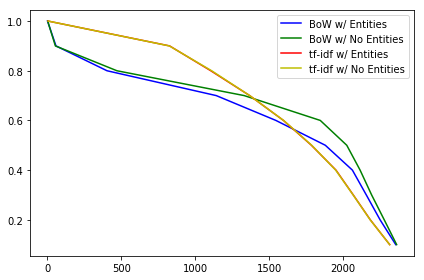

In [16]:
# Visualize clustercounts to help determine optimal bandwidths to run with Mean Shift clusters

sns.set_style()

plt.plot(bandwidth_comparison.bow_entities, bandwidth_comparison.index, label='BoW w/ Entities', color='b')
plt.plot(bandwidth_comparison.bow_no_entities, bandwidth_comparison.index, label='BoW w/ No Entities', color='g')
plt.plot(bandwidth_comparison.lsa_entities, bandwidth_comparison.index, label='tf-idf w/ Entities', color='r')
plt.plot(bandwidth_comparison.lsa_no_entities, bandwidth_comparison.index, label='tf-idf w/ No Entities', color='y')
plt.legend()

plt.tight_layout()
plt.show()

Looks like removing Entities has no impact in this instance, although there are some slight differences between the two feature generation methods. In order for our cluster model to properly predict approximately 50 clusters, our gamma value has to be relatively high:

- BoW Gamma Value: .9
- tf-idf Gamma Value: .98

#### Affinity Propagation

For our Affinity Propagation clustering algorithm, we will be testing different damping parameters with an eye towards optimizing for cluster count.

In [17]:
# Test clustercount predictions as a feature of damping value in affinity propagation

damping_test = [.5, .6, .7, .8, .9, .99]
damping_comparison = pd.DataFrame(columns=name_of_sets, index=damping_test)

for damping in damping_test:
    affinity = AffinityPropagation(damping=damping)
    for set_, name in zip(feature_sets, name_of_sets):
        prediction = affinity.fit(set_)
        label_count = len(np.unique(prediction.labels_))
        damping_comparison.loc[damping, name] = label_count
        print (damping, name)

0.5 bow_entities
0.5 bow_no_entities
0.5 lsa_entities
0.5 lsa_no_entities
0.6 bow_entities
0.6 bow_no_entities
0.6 lsa_entities
0.6 lsa_no_entities
0.7 bow_entities
0.7 bow_no_entities
0.7 lsa_entities
0.7 lsa_no_entities
0.8 bow_entities
0.8 bow_no_entities
0.8 lsa_entities
0.8 lsa_no_entities
0.9 bow_entities
0.9 bow_no_entities
0.9 lsa_entities
0.9 lsa_no_entities
0.99 bow_entities
0.99 bow_no_entities
0.99 lsa_entities
0.99 lsa_no_entities


In [18]:
damping_comparison

,bow_entities,bow_no_entities,lsa_entities,lsa_no_entities
0.50,433,419,490,489
0.60,434,418,491,490
0.70,436,422,491,491
0.80,437,422,491,491
0.90,422,401,480,480
0.99,1,1,14,14


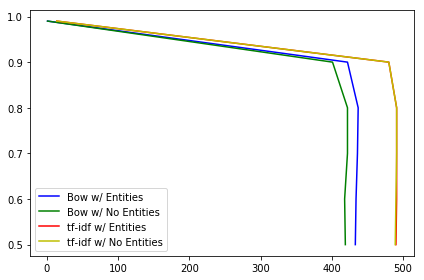

In [19]:
# Visualize clustercounts to help determine optimal damping to run with Affinity Propagation clusters

plt.plot(damping_comparison.bow_entities, damping_comparison.index, label='Bow w/ Entities', color='b')
plt.plot(damping_comparison.bow_no_entities, damping_comparison.index, label='Bow w/ No Entities', color='g')
plt.plot(damping_comparison.lsa_entities, damping_comparison.index, label='tf-idf w/ Entities', color='r')
plt.plot(damping_comparison.lsa_no_entities, damping_comparison.index, label='tf-idf w/ No Entities', color='y')
plt.legend()

plt.tight_layout()
plt.show()

Again it appears that removing Entities has no impact in this instance. There are some slight differences between the two feature generation methods, but too subtle to be particularly impactful. In order for our cluster model to properly predict approximately 50 clusters, our damping parameter has to be relatively high:

- Damping Value: .98

#### Spectral Clustering Tuning

For our Spectral Clustering algorithm, we will be testing different kernel and gamma parameters with an eye towards optimizing for silhouette score.

In [20]:
# Test clustercount predictions as a feature of kernel type and  value in affinity propagation

kernel_test = ['rbf','poly','sigmoid','nearest_neighbors']
gamma_test = [.5, .75, 1, 1.25, 1.5]
kernel_comparison = pd.DataFrame(columns=['features','kernel','gamma','score'])

# Set index counter
i = 0

# Loop through kernels
for kernel in kernel_test:
    # Loop through gammas
    for gamma in gamma_test:
        # Set model specifications
        if kernel == 'nearest_neighbors':
            spectral = SpectralClustering(n_clusters=50, affinity=kernel)
        else:
            spectral = SpectralClustering(n_clusters=50, affinity=kernel, gamma=gamma)
        # Run model on all feature sets
        for set_, name in zip(feature_sets, name_of_sets):
            prediction = spectral.fit(set_)
            labels = prediction.labels_
            silhouette = metrics.silhouette_score(set_, labels, metric='l1') #Using l1 distance so as not to penalize non-globular/non-geometric clusters more 
            # Add info to DataFrame
            kernel_comparison.loc[i, 'features'] = name
            kernel_comparison.loc[i, 'kernel'] = kernel
            kernel_comparison.loc[i, 'gamma'] = gamma
            kernel_comparison.loc[i, 'score'] = silhouette
            # Increment index counter
            i = i+1
            # Print to stay on track
            print (i, kernel, gamma, name)

1 rbf 0.5 bow_entities
2 rbf 0.5 bow_no_entities
3 rbf 0.5 lsa_entities
4 rbf 0.5 lsa_no_entities
5 rbf 0.75 bow_entities
6 rbf 0.75 bow_no_entities
7 rbf 0.75 lsa_entities
8 rbf 0.75 lsa_no_entities
9 rbf 1 bow_entities
10 rbf 1 bow_no_entities
11 rbf 1 lsa_entities
12 rbf 1 lsa_no_entities
13 rbf 1.25 bow_entities
14 rbf 1.25 bow_no_entities
15 rbf 1.25 lsa_entities
16 rbf 1.25 lsa_no_entities
17 rbf 1.5 bow_entities
18 rbf 1.5 bow_no_entities
19 rbf 1.5 lsa_entities
20 rbf 1.5 lsa_no_entities
21 poly 0.5 bow_entities
22 poly 0.5 bow_no_entities
23 poly 0.5 lsa_entities
24 poly 0.5 lsa_no_entities
25 poly 0.75 bow_entities
26 poly 0.75 bow_no_entities
27 poly 0.75 lsa_entities
28 poly 0.75 lsa_no_entities
29 poly 1 bow_entities
30 poly 1 bow_no_entities
31 poly 1 lsa_entities
32 poly 1 lsa_no_entities
33 poly 1.25 bow_entities
34 poly 1.25 bow_no_entities
35 poly 1.25 lsa_entities
36 poly 1.25 lsa_no_entities
37 poly 1.5 bow_entities
38 poly 1.5 bow_no_entities
39 poly 1.5 lsa_entiti

/Users/Albert/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


61 nearest_neighbors 0.5 bow_entities
62 nearest_neighbors 0.5 bow_no_entities
63 nearest_neighbors 0.5 lsa_entities
64 nearest_neighbors 0.5 lsa_no_entities
65 nearest_neighbors 0.75 bow_entities
66 nearest_neighbors 0.75 bow_no_entities
67 nearest_neighbors 0.75 lsa_entities
68 nearest_neighbors 0.75 lsa_no_entities
69 nearest_neighbors 1 bow_entities
70 nearest_neighbors 1 bow_no_entities
71 nearest_neighbors 1 lsa_entities
72 nearest_neighbors 1 lsa_no_entities
73 nearest_neighbors 1.25 bow_entities
74 nearest_neighbors 1.25 bow_no_entities
75 nearest_neighbors 1.25 lsa_entities
76 nearest_neighbors 1.25 lsa_no_entities
77 nearest_neighbors 1.5 bow_entities
78 nearest_neighbors 1.5 bow_no_entities
79 nearest_neighbors 1.5 lsa_entities
80 nearest_neighbors 1.5 lsa_no_entities


In [21]:
kernel_comparison.head()

,features,kernel,gamma,score
0,bow_entities,rbf,0.5,-0.0209951
1,bow_no_entities,rbf,0.5,-0.0154398
2,lsa_entities,rbf,0.5,-0.113369
3,lsa_no_entities,rbf,0.5,-0.112238
4,bow_entities,rbf,0.75,-0.0191199


In [22]:
# Create sub-DataFrames for plotting

kernel_bow_entities = kernel_comparison[kernel_comparison['features']=='bow_entities']
kernel_bow_no_entities = kernel_comparison[kernel_comparison['features']=='bow_no_entities']
kernel_lsa_entities = kernel_comparison[kernel_comparison['features']=='lsa_entities']
kernel_lsa_no_entities = kernel_comparison[kernel_comparison['features']=='lsa_no_entities']

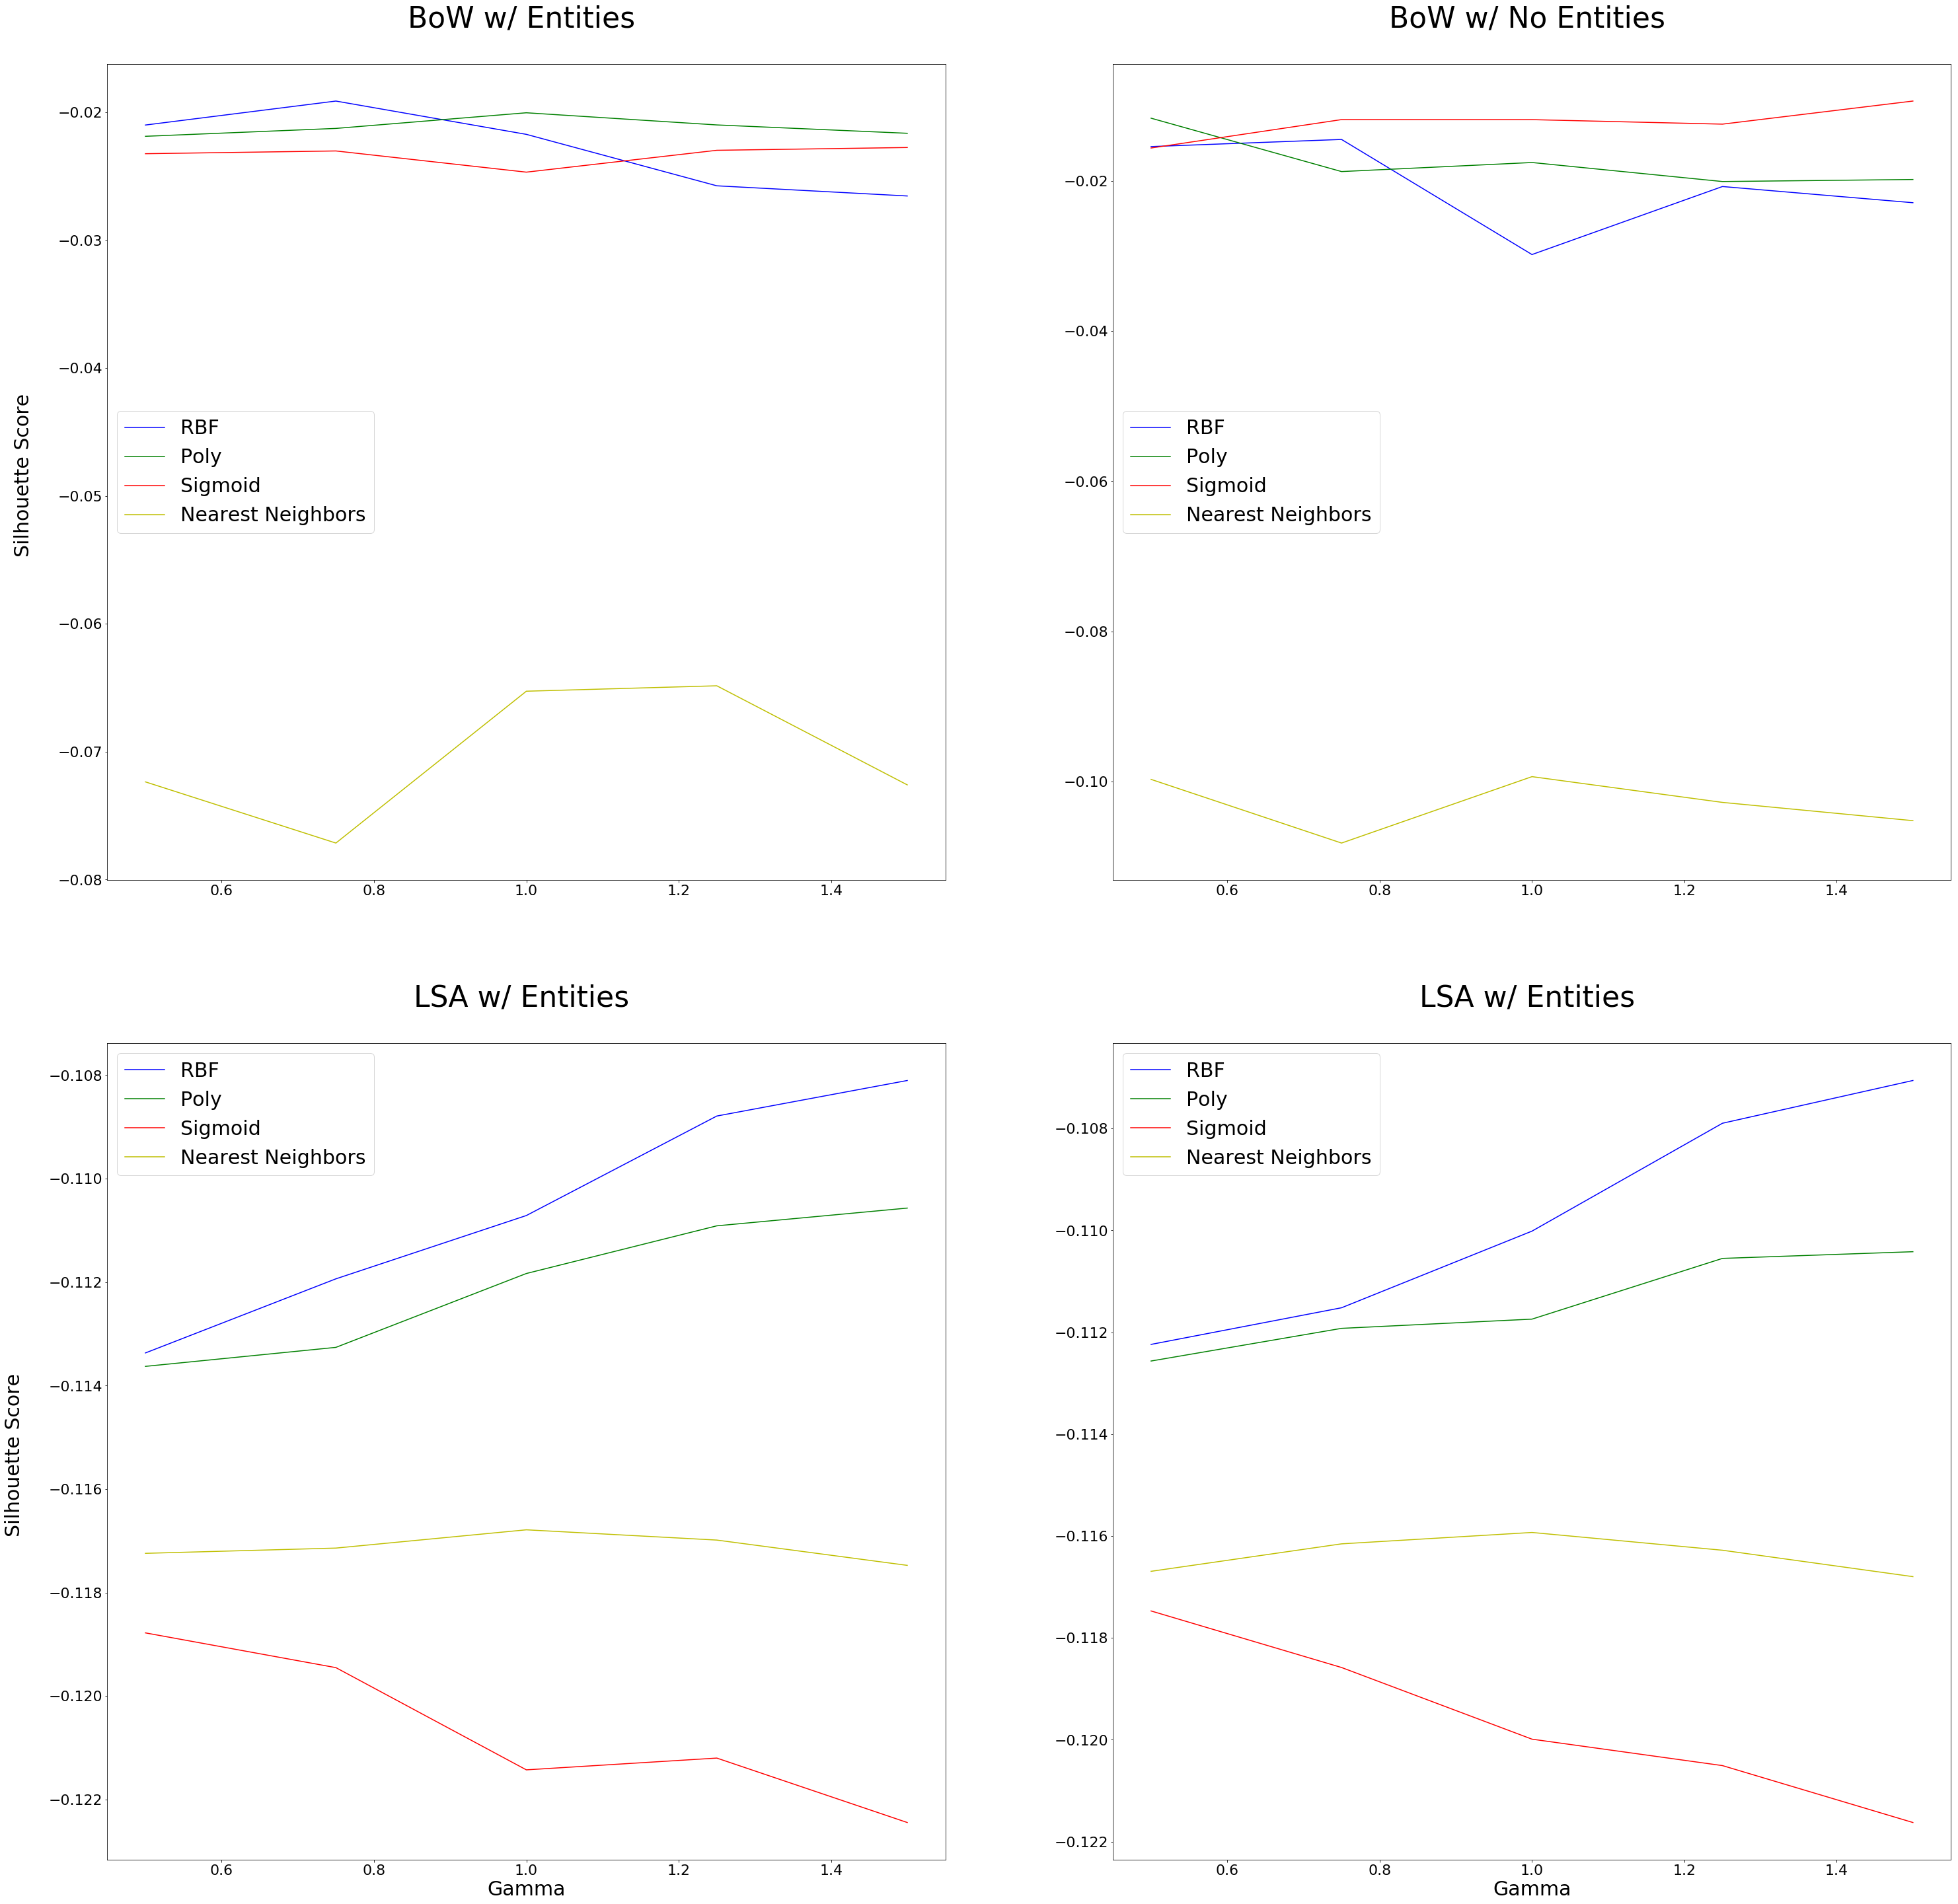

In [23]:
# Visualizing silhouette scores to help determine optimal kernel to run with Spectral clusters

f, ax = plt.subplots(figsize=(50,50))

# Plotting BoW Entities plot
plt.subplot(2,2,1)
plt.plot(kernel_bow_entities[kernel_bow_entities['kernel']=='rbf'].gamma,
         kernel_bow_entities[kernel_bow_entities['kernel']=='rbf'].score,
         label='RBF', color='b')
plt.plot(kernel_bow_entities[kernel_bow_entities['kernel']=='poly'].gamma,
         kernel_bow_entities[kernel_bow_entities['kernel']=='poly'].score,
         label='Poly', color='g')
plt.plot(kernel_bow_entities[kernel_bow_entities['kernel']=='sigmoid'].gamma,
         kernel_bow_entities[kernel_bow_entities['kernel']=='sigmoid'].score,
         label='Sigmoid', color='r')
plt.plot(kernel_bow_entities[kernel_bow_entities['kernel']=='nearest_neighbors'].gamma,
         kernel_bow_entities[kernel_bow_entities['kernel']=='nearest_neighbors'].score,
         label='Nearest Neighbors', color='y')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Silhouette Score \n', size=30)
plt.legend(loc=6, markerscale=3, fontsize=30)
plt.title('BoW w/ Entities \n', fontsize=44)


# Plotting BoW No Entities plot
plt.subplot(2,2,2)
plt.plot(kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='rbf'].gamma,
         kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='rbf'].score,
         label='RBF', color='b')
plt.plot(kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='poly'].gamma,
         kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='poly'].score,
         label='Poly', color='g')
plt.plot(kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='sigmoid'].gamma,
         kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='sigmoid'].score,
         label='Sigmoid', color='r')
plt.plot(kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='nearest_neighbors'].gamma,
         kernel_bow_no_entities[kernel_bow_no_entities['kernel']=='nearest_neighbors'].score,
         label='Nearest Neighbors', color='y')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(loc=6, markerscale=3, fontsize=30)
plt.title('BoW w/ No Entities \n', fontsize=44)


# Plotting LSA Entities plot
plt.subplot(2,2,3)
plt.plot(kernel_lsa_entities[kernel_lsa_entities['kernel']=='rbf'].gamma,
         kernel_lsa_entities[kernel_lsa_entities['kernel']=='rbf'].score,
         label='RBF', color='b')
plt.plot(kernel_lsa_entities[kernel_lsa_entities['kernel']=='poly'].gamma,
         kernel_lsa_entities[kernel_lsa_entities['kernel']=='poly'].score,
         label='Poly', color='g')
plt.plot(kernel_lsa_entities[kernel_lsa_entities['kernel']=='sigmoid'].gamma,
         kernel_lsa_entities[kernel_lsa_entities['kernel']=='sigmoid'].score,
         label='Sigmoid', color='r')
plt.plot(kernel_lsa_entities[kernel_lsa_entities['kernel']=='nearest_neighbors'].gamma,
         kernel_lsa_entities[kernel_lsa_entities['kernel']=='nearest_neighbors'].score,
         label='Nearest Neighbors', color='y')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Gamma', size=30)
plt.ylabel('Silhouette Score \n', size=30)
plt.legend(markerscale=3, fontsize=30)
plt.title('LSA w/ Entities \n', fontsize=44)


# Plotting LSA No Entities plot
plt.subplot(2,2,4)
plt.plot(kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='rbf'].gamma,
         kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='rbf'].score,
         label='RBF', color='b')
plt.plot(kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='poly'].gamma,
         kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='poly'].score,
         label='Poly', color='g')
plt.plot(kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='sigmoid'].gamma,
         kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='sigmoid'].score,
         label='Sigmoid', color='r')
plt.plot(kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='nearest_neighbors'].gamma,
         kernel_lsa_no_entities[kernel_lsa_no_entities['kernel']=='nearest_neighbors'].score,
         label='Nearest Neighbors', color='y')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Gamma', size=30)
plt.legend(markerscale=3, fontsize=30)
plt.title('LSA w/ Entities \n', fontsize=44)


plt.show()

All of these cluster and feature set combinations perform below average. It appears that the LSA features are trending towards standard with increasing gamma value.

Perhaps using a standard RBF kernel with a high gamma value can provide a higher silhouette score.

- Kernel: RBF
- Gamma: 50

## Supervised Learning

Next we'll take a peek at some of our Supervised Learning models. We will utilize the following:
- **Single Vector Classifier**: This is a popular model for data sets with many dimensions
- **Random Forest Classifier**: This is similarly a great model for high dimension data sets, as it uses randomized iterations to get at low bias, low variance scores
- **Gradient Boosting Classifier**: Similar to Random Forest above

In [25]:
# Import relevant Supervised Learning packages
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import cross_val_score as cv_score


# Set values
y = article_df['author_name']

feature_sets = [bow_entities.iloc[:,2:], bow_no_entities.iloc[:,2:], lsa_entities.iloc[:,2:], lsa_no_entities.iloc[:,2:]]
name_of_sets = ['bow_entities','bow_no_entities','lsa_entities','lsa_no_entities']

#### RFC Tuning

We will tune RFC minimum leaf samples with an eye towards optimizing accuracy and minimizing variance

In [26]:
# Set minimum leaf samples to loop through
min_samples = [1, 5, 10, 15, 20, 30, 40, 50]
rfc_comparison = pd.DataFrame(columns=['features','leaves','accuracy','maximum','minimum'])

# Set index counter
i = 0

# Loop through minimum leaf samples
for sample in min_samples:
    rfc = RFC(n_estimators=250, min_samples_leaf=sample)
    # Run model on all feature sets
    for set_, name in zip(feature_sets, name_of_sets):
        cv = cv_score(rfc, set_, y, cv=10)
        # Add info to DataFrame
        rfc_comparison.loc[i, 'features'] = name
        rfc_comparison.loc[i, 'leaves'] = sample
        rfc_comparison.loc[i, 'accuracy'] = cv.mean()
        rfc_comparison.loc[i, 'maximum'] = cv.max()
        rfc_comparison.loc[i, 'minimum'] = cv.min()
        # Increment index counter
        i = i+1
        # Print to stay on track
        print (i, sample, name)

1 1 bow_entities
2 1 bow_no_entities
3 1 lsa_entities
4 1 lsa_no_entities
5 5 bow_entities
6 5 bow_no_entities
7 5 lsa_entities
8 5 lsa_no_entities
9 10 bow_entities
10 10 bow_no_entities
11 10 lsa_entities
12 10 lsa_no_entities
13 15 bow_entities
14 15 bow_no_entities
15 15 lsa_entities
16 15 lsa_no_entities
17 20 bow_entities
18 20 bow_no_entities
19 20 lsa_entities
20 20 lsa_no_entities
21 30 bow_entities
22 30 bow_no_entities
23 30 lsa_entities
24 30 lsa_no_entities
25 40 bow_entities
26 40 bow_no_entities
27 40 lsa_entities
28 40 lsa_no_entities
29 50 bow_entities
30 50 bow_no_entities
31 50 lsa_entities
32 50 lsa_no_entities


In [27]:
rfc_comparison

,features,leaves,accuracy,maximum,minimum
0,bow_entities,1,0.7536,0.776,0.712
1,bow_no_entities,1,0.688,0.728,0.624
2,lsa_entities,1,0.7888,0.82,0.76
3,lsa_no_entities,1,0.7984,0.836,0.748
4,bow_entities,5,0.7504,0.788,0.708
5,bow_no_entities,5,0.6868,0.724,0.644
6,lsa_entities,5,0.77,0.804,0.74
7,lsa_no_entities,5,0.7732,0.816,0.74
8,bow_entities,10,0.7344,0.776,0.676
9,bow_no_entities,10,0.6676,0.704,0.604


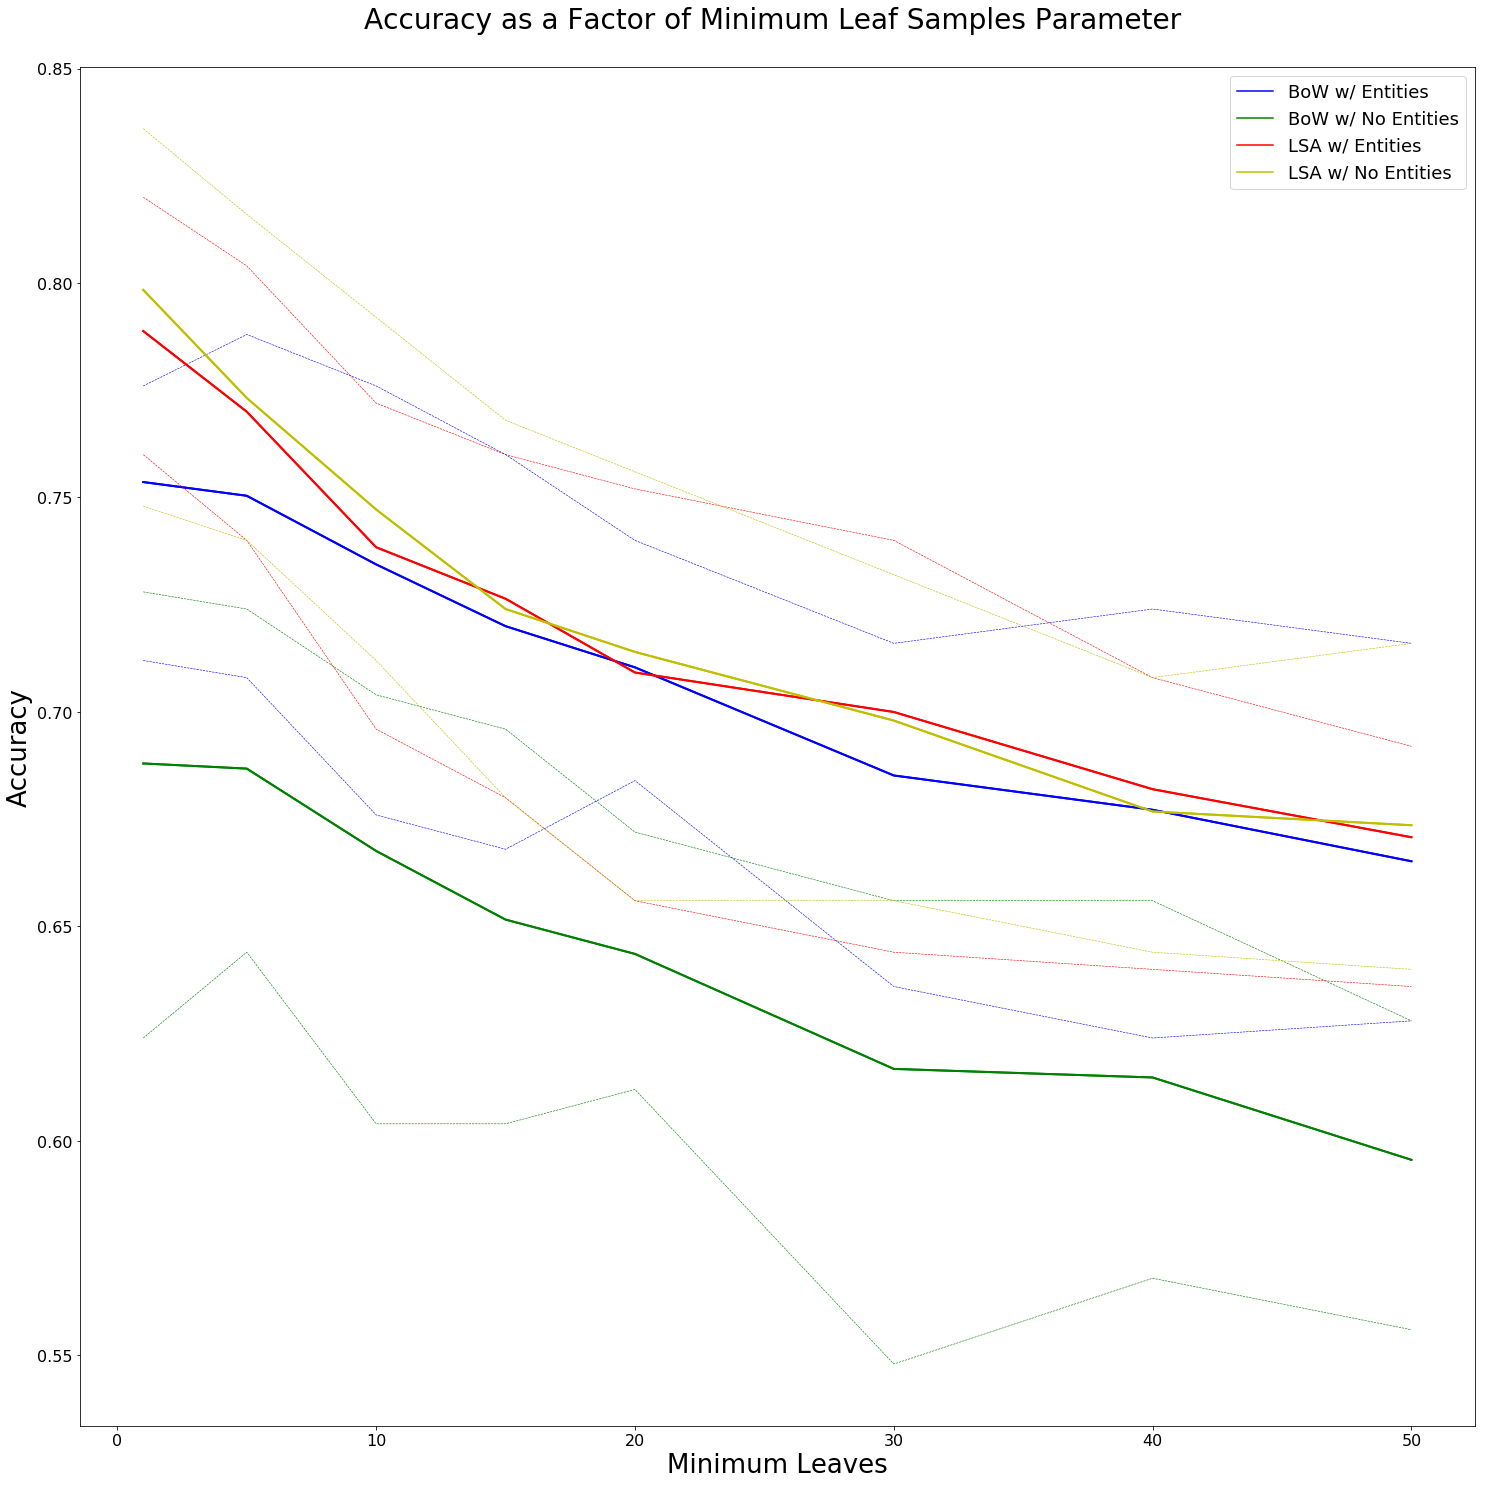

In [28]:
# Writing function to help with plotting
def plot_func (df, feature, color, label):
    plt.plot(df[df['features']==feature].leaves, df[df['features']==feature].accuracy, label=label, color=color, lw=2)
    plt.plot(df[df['features']==feature].leaves, df[df['features']==feature].minimum, color=color, lw=.6, linestyle='--')
    plt.plot(df[df['features']==feature].leaves, df[df['features']==feature].maximum, color=color, lw=.6, linestyle='--')
    
    return plt.plot(df[df['features']==feature].leaves, df[df['features']==feature].accuracy, label=label, color=color, lw=2)
    
# Setting up lists for for loops
name_of_sets = ['bow_entities','bow_no_entities','lsa_entities','lsa_no_entities']
colors = ['b','g','r','y']
labels = ['BoW w/ Entities','BoW w/ No Entities','LSA w/ Entities','LSA w/ No Entities']
handles = []

# Plot accuracy plot of all iterations
f, ax = plt.subplots(figsize=(25,25))

for feature, color, label in zip(name_of_sets, colors, labels):
    plot_func(rfc_comparison, feature, color, label)
    handles.append(mlines.Line2D([],[], color=color))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Minimum Leaves', size=26)
plt.ylabel('Accuracy', size=26)
plt.legend(handles=handles, labels=labels, markerscale=2.5, fontsize=18)
plt.title('Accuracy as a Factor of Minimum Leaf Samples Parameter \n', fontsize=28)
plt.show()

Our optimal leaf count in this situation is 1

#### GBC Tuning

We will tune GBC minimum leaf samples with an eye towards optimizing accuracy and minimizing variance

In [29]:
# Set minimum leaf samples to loop through
min_samples = [1, 5, 10, 15, 20, 30, 40, 50]
gbc_comparison = pd.DataFrame(columns=['features','leaves','accuracy','maximum','minimum'])

# Set index counter
i = 0

# Loop through minimum leaf samples
for sample in min_samples:
    gbc = GBC(n_estimators=250, min_samples_leaf=sample)
    # Run model on all feature sets
    for set_, name in zip(feature_sets, name_of_sets):
        cv = cv_score(rfc, set_, y, cv=10)
        # Add info to DataFrame
        gbc_comparison.loc[i, 'features'] = name
        gbc_comparison.loc[i, 'leaves'] = sample
        gbc_comparison.loc[i, 'accuracy'] = cv.mean()
        gbc_comparison.loc[i, 'maximum'] = cv.max()
        gbc_comparison.loc[i, 'minimum'] = cv.min()
        # Increment index counter
        i = i+1
        # Print to stay on track
        print (i, sample, name)

1 1 bow_entities
2 1 bow_no_entities
3 1 lsa_entities
4 1 lsa_no_entities
5 5 bow_entities
6 5 bow_no_entities
7 5 lsa_entities
8 5 lsa_no_entities
9 10 bow_entities
10 10 bow_no_entities
11 10 lsa_entities
12 10 lsa_no_entities
13 15 bow_entities
14 15 bow_no_entities
15 15 lsa_entities
16 15 lsa_no_entities
17 20 bow_entities
18 20 bow_no_entities
19 20 lsa_entities
20 20 lsa_no_entities
21 30 bow_entities
22 30 bow_no_entities
23 30 lsa_entities
24 30 lsa_no_entities
25 40 bow_entities
26 40 bow_no_entities
27 40 lsa_entities
28 40 lsa_no_entities
29 50 bow_entities
30 50 bow_no_entities
31 50 lsa_entities
32 50 lsa_no_entities


In [30]:
gbc_comparison.head()

,features,leaves,accuracy,maximum,minimum
0,bow_entities,1,0.6652,0.716,0.616
1,bow_no_entities,1,0.5956,0.628,0.56
2,lsa_entities,1,0.672,0.704,0.628
3,lsa_no_entities,1,0.6696,0.696,0.632
4,bow_entities,5,0.6656,0.7,0.608


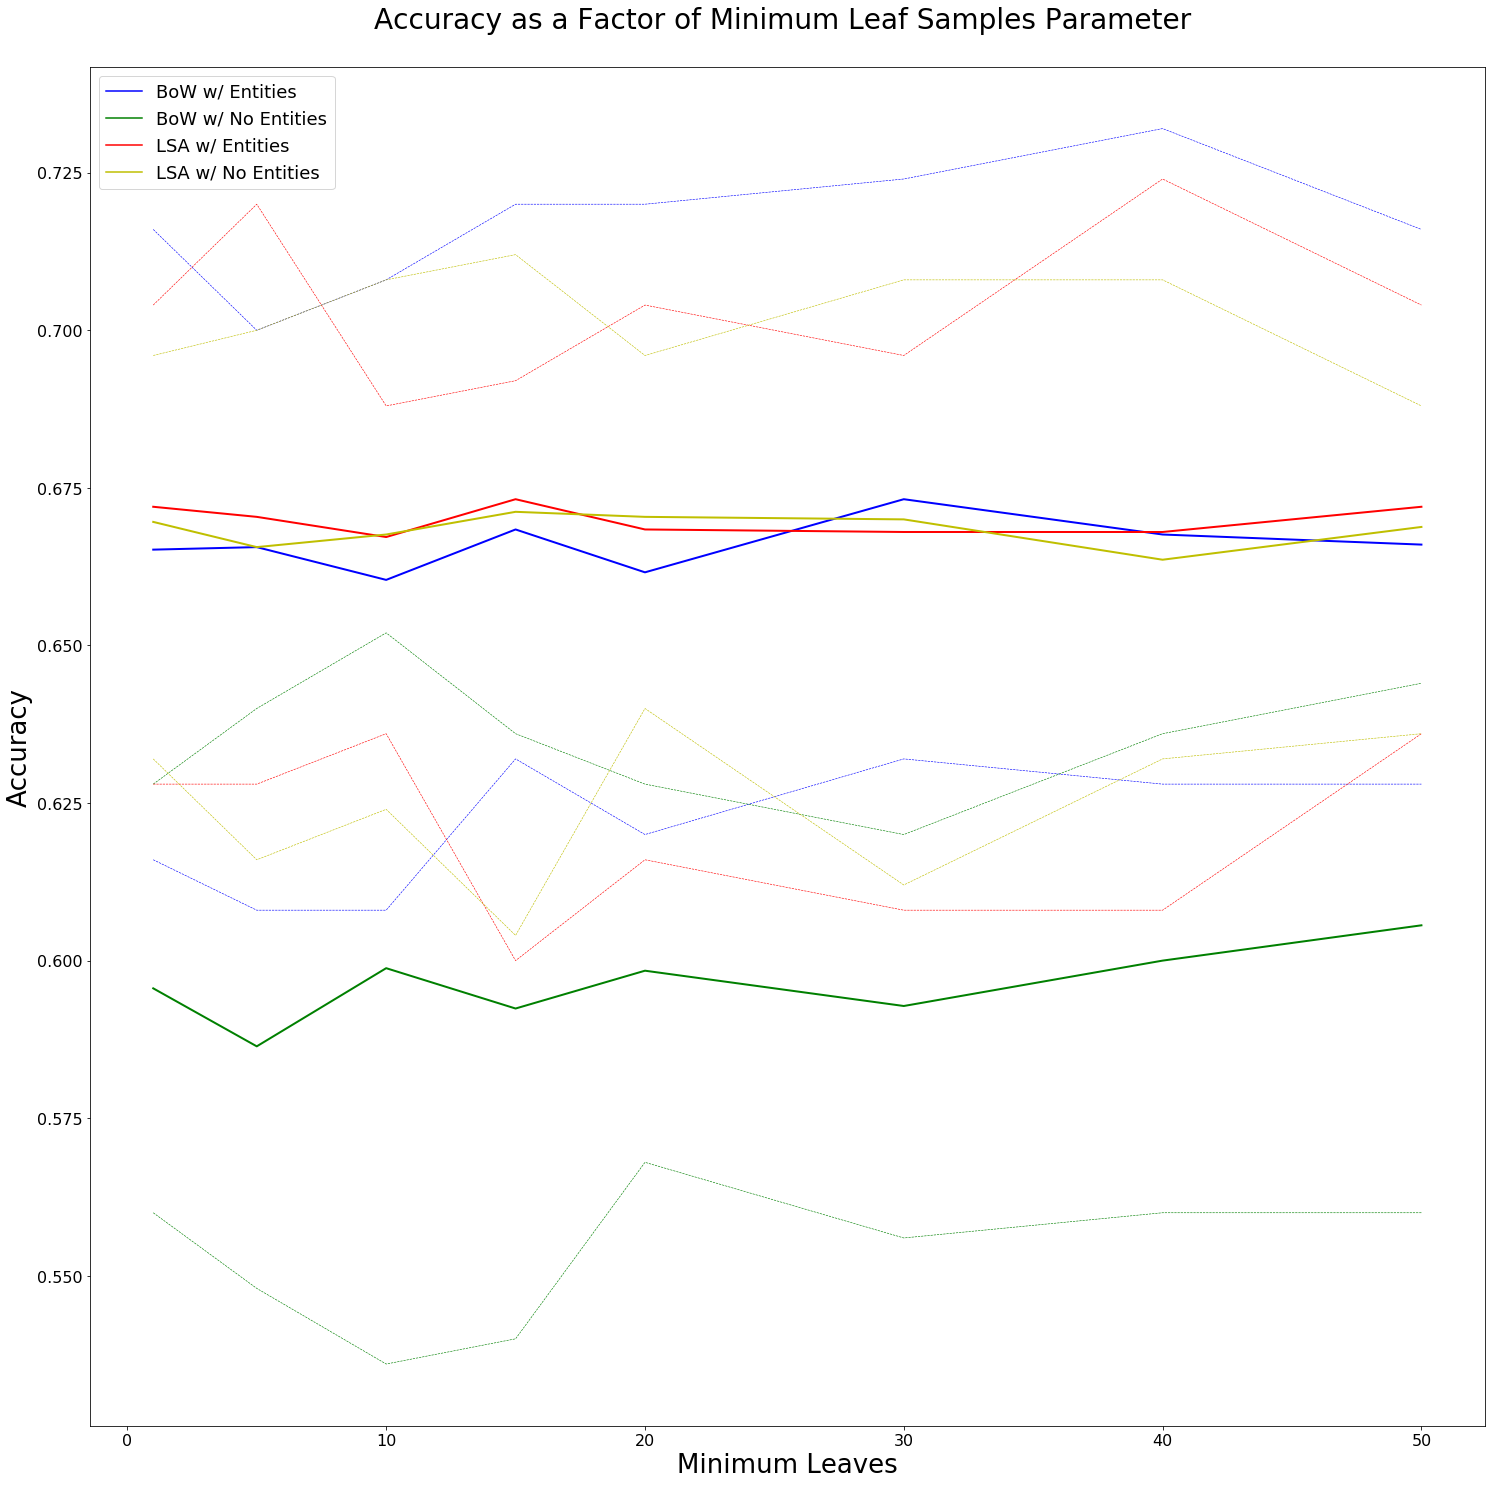

In [31]:
# Writing function to help with plotting
def plot_func (df, feature, color, label):
    plt.plot(df[df['features']==feature].leaves, df[df['features']==feature].accuracy, label=label, color=color, lw=2)
    plt.plot(df[df['features']==feature].leaves, df[df['features']==feature].minimum, color=color, lw=.6, linestyle='--')
    plt.plot(df[df['features']==feature].leaves, df[df['features']==feature].maximum, color=color, lw=.6, linestyle='--')
    
# Setting up lists for for loops
name_of_sets = ['bow_entities','bow_no_entities','lsa_entities','lsa_no_entities']
colors = ['b','g','r','y']
labels = ['BoW w/ Entities','BoW w/ No Entities','LSA w/ Entities','LSA w/ No Entities']
handles = []

# Plot accuracy plot of all iterations
f, ax = plt.subplots(figsize=(25,25))

for feature, color, label in zip(name_of_sets, colors, labels):
    plot_func(gbc_comparison, feature, color, label)
    handles.append(mlines.Line2D([],[], color=color))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Minimum Leaves', size=26)
plt.ylabel('Accuracy', size=26)
plt.legend(handles=handles, labels=labels, markerscale=2.5, fontsize=18)
plt.title('Accuracy as a Factor of Minimum Leaf Samples Parameter \n', fontsize=28)
plt.show()

Much less effective, and higher overall variance than RFC. We'll remove this model from our analysis.

#### SVC Tuning

We will tune SVC gamma parameters with an eye towards optimizing accuracy and minimizing variance

In [32]:
# Test prediction accuracy and variance as a feature of kernel type and gamma for SVC

kernel_test = ['rbf','poly','sigmoid','linear']
gamma_C_test = [.5, 1, 5, 10, 20, 30, 40, 50, 75, 100]
svc_comparison = pd.DataFrame(columns=['features','kernel','gamma','accuracy','maximum','minimum'])

# Set index counter
i = 0

# Loop through kernels
for kernel in kernel_test:
    # Loop through gammas
    for gamma in gamma_C_test:
        # Set model specifications
        if kernel == 'linear':
            svc = SVC(C=gamma, kernel=kernel)
        else:
            svc = SVC(gamma=gamma, kernel=kernel)
        # Run model on all feature sets
        for set_, name in zip(feature_sets, name_of_sets):
            cv = cv_score(svc, set_, y, cv=10)
            # Add info to DataFrame
            svc_comparison.loc[i, 'features'] = name
            svc_comparison.loc[i, 'kernel'] = kernel
            svc_comparison.loc[i, 'gamma'] = gamma
            svc_comparison.loc[i, 'accuracy'] = cv.mean()
            svc_comparison.loc[i, 'maximum'] = cv.max()
            svc_comparison.loc[i, 'minimum'] = cv.min()
            # Increment index counter
            i = i+1
            # Print to stay on track
            print (i, kernel, gamma, name)

1 rbf 0.5 bow_entities
2 rbf 0.5 bow_no_entities
3 rbf 0.5 lsa_entities
4 rbf 0.5 lsa_no_entities
5 rbf 1 bow_entities
6 rbf 1 bow_no_entities
7 rbf 1 lsa_entities
8 rbf 1 lsa_no_entities
9 rbf 5 bow_entities
10 rbf 5 bow_no_entities
11 rbf 5 lsa_entities
12 rbf 5 lsa_no_entities
13 rbf 10 bow_entities
14 rbf 10 bow_no_entities
15 rbf 10 lsa_entities
16 rbf 10 lsa_no_entities
17 rbf 20 bow_entities
18 rbf 20 bow_no_entities
19 rbf 20 lsa_entities
20 rbf 20 lsa_no_entities
21 rbf 30 bow_entities
22 rbf 30 bow_no_entities
23 rbf 30 lsa_entities
24 rbf 30 lsa_no_entities
25 rbf 40 bow_entities
26 rbf 40 bow_no_entities
27 rbf 40 lsa_entities
28 rbf 40 lsa_no_entities
29 rbf 50 bow_entities
30 rbf 50 bow_no_entities
31 rbf 50 lsa_entities
32 rbf 50 lsa_no_entities
33 rbf 75 bow_entities
34 rbf 75 bow_no_entities
35 rbf 75 lsa_entities
36 rbf 75 lsa_no_entities
37 rbf 100 bow_entities
38 rbf 100 bow_no_entities
39 rbf 100 lsa_entities
40 rbf 100 lsa_no_entities
41 poly 0.5 bow_entities
42 p

In [33]:
svc_comparison

,features,kernel,gamma,accuracy,maximum,minimum
0,bow_entities,rbf,0.5,0.788,0.832,0.74
1,bow_no_entities,rbf,0.5,0.7484,0.784,0.692
2,lsa_entities,rbf,0.5,0.7936,0.816,0.772
3,lsa_no_entities,rbf,0.5,0.7928,0.812,0.768
4,bow_entities,rbf,1,0.8068,0.832,0.768
5,bow_no_entities,rbf,1,0.784,0.812,0.736
6,lsa_entities,rbf,1,0.806,0.824,0.792
7,lsa_no_entities,rbf,1,0.8068,0.824,0.792
8,bow_entities,rbf,5,0.722,0.756,0.696
9,bow_no_entities,rbf,5,0.68,0.712,0.636


In [34]:
# Create sub-DataFrames for plotting
svc_bow_entities = svc_comparison[svc_comparison['features']=='bow_entities']
svc_bow_no_entities = svc_comparison[svc_comparison['features']=='bow_no_entities']
svc_lsa_entities = svc_comparison[svc_comparison['features']=='lsa_entities']
svc_lsa_no_entities = svc_comparison[svc_comparison['features']=='lsa_no_entities']

# Writing function to help with plotting
def svc_plot_func (df, kernel, color, label):
    plt.plot(df[df['kernel']==kernel].gamma, df[df['kernel']==kernel].accuracy, label=label, color=color, lw=2)
    plt.plot(df[df['kernel']==kernel].gamma, df[df['kernel']==kernel].minimum, color=color, lw=.6, linestyle='--')
    plt.plot(df[df['kernel']==kernel].gamma, df[df['kernel']==kernel].maximum, color=color, lw=.6, linestyle='--')

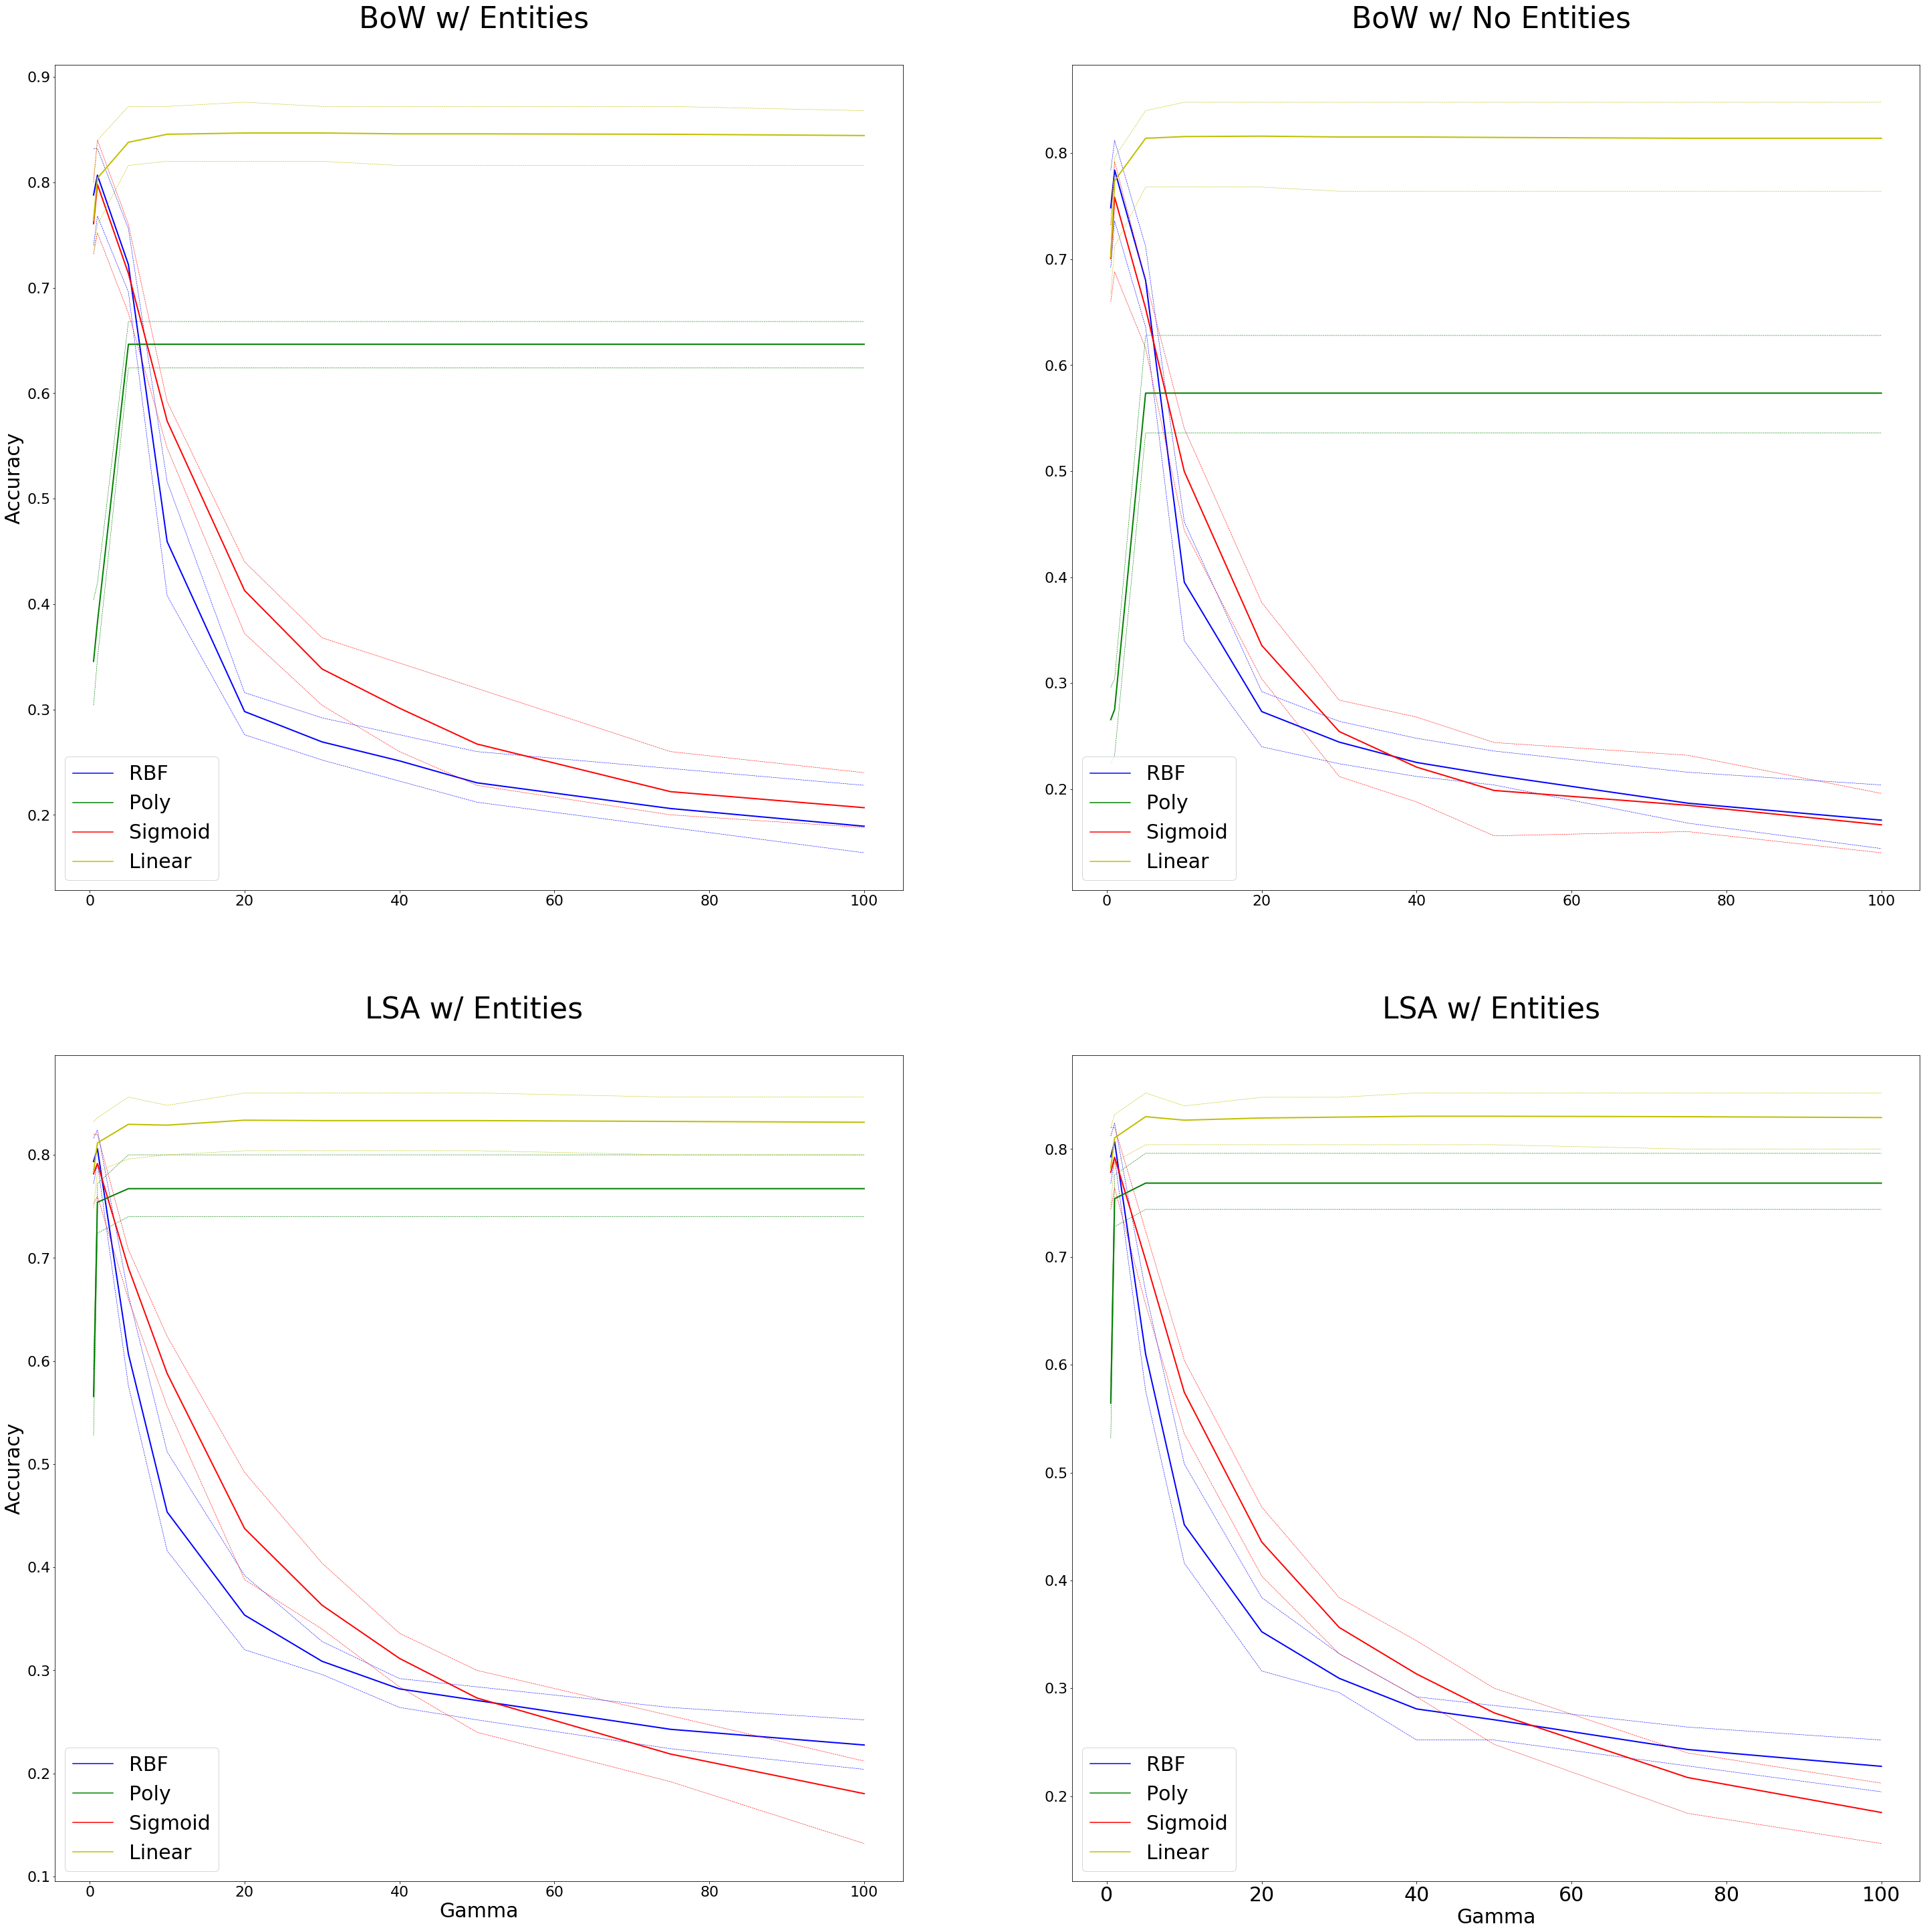

In [35]:
# Setting up lists for for loops
kernel_test = ['rbf','poly','sigmoid','linear']
kernel_labels = ['RBF','Poly','Sigmoid','Linear']
colors = ['b','g','r','y']
handles = []


# Visualizing accuracy and variance to help determine optimal kernel and gamme to run with SVC
f, ax = plt.subplots(figsize=(50,50))

plt.subplot(2,2,1)
for kernel, color, label in zip(kernel_test, colors, kernel_labels):
    svc_plot_func(svc_bow_entities, kernel, color, label)
    handles.append(mlines.Line2D([],[], color=color))

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Accuracy', size=30)
plt.legend(handles=handles, labels=kernel_labels, markerscale=3, fontsize=30)
plt.title('BoW w/ Entities \n', fontsize=44)

    
plt.subplot(2,2,2)
for kernel, color, label in zip(kernel_test, colors, kernel_labels):
    svc_plot_func(svc_bow_no_entities, kernel, color, label)
    
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(handles=handles, labels=kernel_labels, markerscale=3, fontsize=30, loc=3)
plt.title('BoW w/ No Entities \n', fontsize=44)

    
plt.subplot(2,2,3)
for kernel, color, label in zip(kernel_test, colors, kernel_labels):
    svc_plot_func(svc_lsa_entities, kernel, color, label)
    
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Accuracy', size=30)
plt.xlabel('Gamma', size=30)
plt.legend(handles=handles, labels=kernel_labels, markerscale=3, fontsize=30)
plt.title('LSA w/ Entities \n', fontsize=44)

    
plt.subplot(2,2,4)
for kernel, color, label in zip(kernel_test, colors, kernel_labels):
    svc_plot_func(svc_lsa_no_entities, kernel, color, label)
    
plt.xticks(fontsize=30)
plt.yticks(fontsize=22)
plt.xlabel('Gamma', size=30)
plt.legend(handles=handles, labels=kernel_labels, markerscale=3, fontsize=30)
plt.title('LSA w/ Entities \n', fontsize=44)


plt.show()

Looks like SVC is the best model in this situation. Particularly the Linear kernel, with a C value at or greater than 5

## Final Testing

#### Importing Test Dataset

In [36]:
# Import test set

# Set directory for reading test articles
import os
os.chdir('/Users/Albert/Desktop/Thinkful_Drills/Data/Unsupervised Learning/C50/C50test')

# Load English language option in spaCy
nlp = spacy.load('en')

# Set blank list for data
article_read_test = []

# Create for loop to open each author folder
for author in sorted(os.listdir('.'))[1:]:
    # Create for loop to read each article in folder
    path = os.path.join('.', author)
    for article in os.listdir(path):
        # Read article
        file = open(os.path.join(path, article), 'r')
        text = file.read()
        # Clean text of end of article notations and characters spaCy cannot read
        text = re.sub('\-\-.*$', '', text)
        text = re.sub('\(\(.*$', '', text)
        text = re.sub(r'-', ' ', text)
        text = ' '.join(text.split())
        # Parse data using spaCy
        text = nlp(text)
        # Create separate set of tokens with no entities for later use in feature creation
        text_no_entities = text.text
        for entity in text.ents:
            text_no_entities = text_no_entities.replace(entity.text, '')
        text_no_entities = ' '.join(text_no_entities.split())
        text_no_entities = nlp(text_no_entities)
        # Append all information to articles list
        article_read_test.append([text, text_no_entities, author])
    # Print author to keep track of where parsing code is
    print (author)

        
# Convert article list to Pandas DataFrame
test_df = pd.DataFrame(article_read_test, columns=['article_text','article_no_entities','author_name'])
test_df.head()

AaronPressman
AlanCrosby
AlexanderSmith
BenjaminKangLim
BernardHickey
BradDorfman
DarrenSchuettler
DavidLawder
EdnaFernandes
EricAuchard
FumikoFujisaki
GrahamEarnshaw
HeatherScoffield
JanLopatka
JaneMacartney
JimGilchrist
JoWinterbottom
JoeOrtiz
JohnMastrini
JonathanBirt
KarlPenhaul
KeithWeir
KevinDrawbaugh
KevinMorrison
KirstinRidley
KouroshKarimkhany
LydiaZajc
LynneO'Donnell
LynnleyBrowning
MarcelMichelson
MarkBendeich
MartinWolk
MatthewBunce
MichaelConnor
MureDickie
NickLouth
PatriciaCommins
PeterHumphrey
PierreTran
RobinSidel
RogerFillion
SamuelPerry
SarahDavison
ScottHillis
SimonCowell
TanEeLyn
TheresePoletti
TimFarrand
ToddNissen
WilliamKazer


,article_text,article_no_entities,author_name
0,"(The, U.S., government, is, scrambling, to, up...","(The, government, is, scrambling, to, update, ...",AaronPressman
1,"(The, chairman, of, an, influential, National,...","(The, chairman, of, an, influential, report, o...",AaronPressman
2,"(Federal, Reserve, Chairman, Alan, Greenspan, ...","(Chairman, urged, lawmakers, on, to, put, off,...",AaronPressman
3,"(Privacy, advocates, warned, Wednesday, that, ...","(Privacy, advocates, warned, that, the, admini...",AaronPressman
4,"(The, heads, of, 10, leading, U.S., high, tech...","(The, heads, of, leading, high, technology, co...",AaronPressman


In [37]:
test_df.shape

(2500, 3)

#### BoW Feature Generation

In [38]:
# Create a set of article strings by author to help with BoW feature creation
text_by_author = []
text_by_author_no_entities = []


for author in test_df.author_name.unique():
    for text in test_df[test_df['author_name'] == author].article_text:
        text_aggregator = ''
        text_aggregator = text_aggregator + ' ' + str(text)
        text_by_author.append([text_aggregator, author])
    for text in test_df[test_df['author_name'] == author].article_no_entities:
        text_aggregator = ''
        text_aggregator = text_aggregator + ' ' + str(text)
        text_by_author_no_entities.append([text_aggregator, author])
    
    
# Pull desired set of words from text for both feature set types
common_words = set()
common_words_no_entities = set()

for author in text_by_author:
    words_bagged_by_author = bag_of_words(nlp(author[0]))
    common_words = common_words.union(words_bagged_by_author)
    
for author in text_by_author_no_entities:
    words_bagged_by_author = bag_of_words(nlp(author[0]))
    common_words_no_entities = common_words_no_entities.union(words_bagged_by_author)


# Convert to DataFrame for each feature set type
bow_entities_test = bow_features(test_df[['article_text','author_name']], common_words)
print(bow_entities_test.shape)

bow_no_entities_test = bow_features(test_df[['article_no_entities','author_name']], common_words_no_entities)
print(bow_no_entities_test.shape)

(2500, 27904)
(2500, 16065)


In [39]:
# Prep data and set dimension target
normed1 = normalize(bow_entities_test.iloc[:,2:])
normed2 = normalize(bow_no_entities_test.iloc[:,2:])
pca = PCA(850)

# Run PCA to reduce BoW dimensions to 850
bow_entities_test = pca.fit_transform(normed1)
bow_entities_test = pd.DataFrame(bow_entities_test)
print('BoW PCA contains {:.3f}% of original variance'.format(pca.explained_variance_ratio_.sum()*100))

bow_no_entities_test = pca.fit_transform(normed2)
bow_no_entities_test = pd.DataFrame(bow_no_entities_test)
print('BoW No Entities PCA contains {:.3f}% of original variance'.format(pca.explained_variance_ratio_.sum()*100))

BoW PCA contains 88.240% of original variance
BoW No Entities PCA contains 90.407% of original variance


#### tf-idf Feature Generation

In [40]:
# Create sets of articles to transform using tf-idf vectorizer
list_of_articles = [article.text for article in test_df.article_text]
list_of_articles_no_entities = [article.text for article in test_df.article_no_entities]

# Import and set parameters for tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.4, # drop words that occur in more than 40% of articles
                             min_df=5, # only use words that appear in at least 5 articles
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm='l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Apply the vectorizer
articles_tfidf=vectorizer.fit_transform(list_of_articles)
print("Number of features in articles: {}".format(articles_tfidf.get_shape()[1]))

articles_no_entities_tfidf=vectorizer.fit_transform(list_of_articles_no_entities)
print("Number of features in articles with no entities: {}".format(articles_no_entities_tfidf.get_shape()[1]))

Number of features in articles: 10575
Number of features in articles with no entities: 8294


In [41]:
# Import packages for transforming our applying LSA to our tf-idf matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer. We are going to reduce the feature space to 250 dimensions.
svd = TruncatedSVD(850)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on both feature sets
article_lsa = lsa.fit_transform(articles_tfidf)
variance_explained_1=svd.explained_variance_ratio_

article_no_entities_lsa = lsa.fit_transform(articles_tfidf)
variance_explained_2=svd.explained_variance_ratio_

print("Percent variance captured by article components:", variance_explained_1.sum()*100)
print("Percent variance captured by article components with no entities:", variance_explained_2.sum()*100)

#Converting to DataFrame
lsa_entities_test = pd.concat([article_df[['article_text','author_name']], pd.DataFrame(article_lsa)], axis=1, ignore_index=True)
lsa_no_entities_test = pd.concat([article_df[['article_no_entities','author_name']], pd.DataFrame(article_no_entities_lsa)], axis=1, ignore_index=True)

Percent variance captured by article components: 81.50504930565381
Percent variance captured by article components with no entities: 81.50336268037715


#### Comparing Test/Train Across All Models

In [46]:
# Instantiate cluster models
kmeans = KMeans(n_clusters=50)
meanshift_bow = MeanShift(bandwidth=.9)
meanshift_lsa = MeanShift(bandwidth=.98)
affinity = AffinityPropagation(damping=.9)
spectral = SpectralClustering(n_clusters=50, affinity='rbf', gamma=50)

# Instantiate supervised learning models
rfc = RFC(n_estimators=250)
svc = SVC(kernel='linear', C=5)

In [47]:
# Create DataFrame
name_of_models = ['KMeans','MeanShift','Affinity Propogation','Spectral Clustering','Random Forest Classifier','Linear SVM']
name_of_sets = ['Bow w/ Entities','Bow w/ No Entities','LSA Entities','LSA w/ No Entities']

index = pd.MultiIndex.from_product([name_of_models, name_of_sets], names=['models','feature_sets'])
final_test = pd.DataFrame(index=index, columns=['train','test','difference'])


# Set feature sets and models for testing
train_feature_sets = [bow_entities.iloc[:,2:], bow_no_entities.iloc[:,2:], lsa_entities.iloc[:,2:], lsa_no_entities.iloc[:,2:]]
test_feature_sets = [bow_entities_test.iloc[:,2:], bow_no_entities_test.iloc[:,2:], lsa_entities_test.iloc[:,2:], lsa_no_entities_test.iloc[:,2:]]
clusters = [kmeans, [meanshift_bow, meanshift_lsa], affinity, spectral]
supervised = [rfc, svc]

In [50]:
# Populate DataFrame with cluster results
for model, model_name in zip (clusters, name_of_models[:4]):
    if model_name == 'MeanShift':
        for train, test, set_name in zip (train_feature_sets[:2], test_feature_sets[:2], name_of_sets[:2]):
            # Append silhouette score for train data set
            train_predict = model[0].fit(train)
            train_labels = train_predict.labels_
            train_silhouette = metrics.silhouette_score(train, train_labels, metric='l1') #Using l1 distance so as not to penalize non-globular/non-geometric clusters more 
            final_test.loc[(model_name, set_name), 'train'] = train_silhouette
            # Append silhouette score for test data set
            test_predict = model[0].fit(test)
            test_labels = test_predict.labels_
            test_silhouette = metrics.silhouette_score(test, test_labels, metric='l1') #Using l1 distance so as not to penalize non-globular/non-geometric clusters more 
            final_test.loc[(model_name, set_name), 'test'] = test_silhouette            
        for train, test, set_name in zip (train_feature_sets[2:], test_feature_sets[2:], name_of_sets[2:]):
            # Append silhouette score for train data set
            train_predict = model[1].fit(train)
            train_labels = train_predict.labels_
            train_silhouette = metrics.silhouette_score(train, train_labels, metric='l1') #Using l1 distance so as not to penalize non-globular/non-geometric clusters more 
            final_test.loc[(model_name, set_name), 'train'] = train_silhouette
            # Append silhouette score for test data set
            test_predict = model[1].fit(test)
            test_labels = test_predict.labels_
            test_silhouette = metrics.silhouette_score(test, test_labels, metric='l1') #Using l1 distance so as not to penalize non-globular/non-geometric clusters more 
            final_test.loc[(model_name, set_name), 'test'] = test_silhouette            
    else:
        for train, test, set_name in zip (train_feature_sets, test_feature_sets, name_of_sets):
            # Append silhouette score for train data set
            train_predict = model.fit(train)
            train_labels = train_predict.labels_
            train_silhouette = metrics.silhouette_score(train, train_labels, metric='l1') #Using l1 distance so as not to penalize non-globular/non-geometric clusters more 
            final_test.loc[(model_name, set_name), 'train'] = train_silhouette
            # Append silhouette score for test data set
            test_predict = model.fit(test)
            test_labels = test_predict.labels_
            test_silhouette = metrics.silhouette_score(test, test_labels, metric='l1') #Using l1 distance so as not to penalize non-globular/non-geometric clusters more 
            final_test.loc[(model_name, set_name), 'test'] = test_silhouette                  
            print(model_name, set_name)

KMeans Bow w/ Entities
KMeans Bow w/ No Entities
KMeans LSA Entities
KMeans LSA w/ No Entities
Affinity Propogation Bow w/ Entities


/Users/Albert/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


Affinity Propogation Bow w/ No Entities
Affinity Propogation LSA Entities
Affinity Propogation LSA w/ No Entities


KeyboardInterrupt: 

In [51]:
# Populate DataFrame with supervised learning results
for model, model_name in zip (supervised, name_of_models[4:]):
    for train, test, set_name in zip (train_feature_sets, test_feature_sets, name_of_sets):
        # Fit model
        fit_model = model.fit(train, y)
        # Append test and train scores
        train_accuracy = fit_model.score(train, y)
        test_accuracy = fit_model.score(test, y)
        final_test.loc[(model_name, set_name), 'train'] = train_accuracy
        final_test.loc[(model_name, set_name), 'test'] = test_accuracy
        print (model_name, set_name)

KeyboardInterrupt: 

In [ ]:
final_test['difference'] = (final_test['test']-final_test['train'])/final_test('train')

In [ ]:
final_test

## Conclusion

The only possible conclusions here are that aiming to predict authors using NLP requires waaaay more substantial amounts of data than was available here. 50 entries for every category is no enough, and 50 categories to predict is way too much.

## Word2Vec Sidequest!

In [ ]:
list_of_articles_tokenized = []
for article in article_df.article_text:
    article = [
        token.lemma_.lower()
        for token in article
        if not token.is_punct
        and not token.is_stop
    ]
    list_of_articles_tokenized.append(article)
    
list_of_articles_no_entities_tokenized = []
for article in article_df.article_no_entities:
    article = [
        token.lemma_.lower()
        for token in article
        if not token.is_punct
        and not token.is_stop
    ]
    list_of_articles_no_entities_tokenized.append(article)

In [ ]:
type(list_of_articles_tokenized[0][0])

In [ ]:
# Import word2vec package and run it
import gensim
from gensim.models import Word2Vec

word2vec_entities = Word2Vec(
    list_of_articles_tokenized,
    workers=1,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=1,   # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size= 100,     # Word vector length.
    hs=1           # Use hierarchical softmax.
)

In [ ]:
word2vec_no_entities = Word2Vec(
    list_of_articles_no_entitites_tokenized,
    workers=1,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=1,   # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=100,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

In [ ]:
dataset=[1,2,3,4,5]

if not dataset[2:2]:
    print(5)

In [ ]:
for i in range(0,1):
    print (dataset[i])